<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/CosmicNeutrons/CosmicNeutronData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Init

In [1]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
from scipy.interpolate import interp1d

%pip -q install uproot3
%pip -q install --upgrade tables
import uproot3

# This allows you to run on Colaboratory and load files from your Google Drive
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/MyDrive/'
except:
    main_path = ''
sys.path.append(main_path)
sys.path.append(main_path+'root_files_dzhadan')
import math

!pip install fsspec
import dask.dataframe as dd

S = pow(100*100, 2) #100x100 m2 in cm2 - simulated area

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install -I git+https://github.com/oksuzian/mu2etools.git
from mu2etools import utils, cuts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/oksuzian/mu2etools.git to /tmp/pip-req-build-g7e404te
  Running command git clone --filter=blob:none --quiet https://github.com/oksuzian/mu2etools.git /tmp/pip-req-build-g7e404te
  Resolved https://github.com/oksuzian/mu2etools.git to commit 1b8a2b88b5ce01e074aa5e1b62ecc36c5bfa5dfe
  Preparing metadata (setup.py) ... done
  Created wheel for mu2etools: filename=mu2etools-0.0.1-py3-none-any.whl size=5980 sha256=df1876202934497e10f67fad640f2bdf75601ee7071635a95386e82f3dbfd8bb
  Stored in directory: /tmp/pip-ephem-wheel-cache-xoedqe3j/wheels/22/2c/26/13c9f2a4907e455fc9d904ab23966906dc99d02d070ab5f347
Successfully built mu2etools


In [3]:
def GetNeutKE(df):
  nmass = 936 # MeV, neutron mass
  df_neut = df.query('demcgen_pdg==2112')
  mom2 = df_neut.demcgen_momx*df_neut.demcgen_momx+df_neut.demcgen_momy*df_neut.demcgen_momy+df_neut.demcgen_momz*df_neut.demcgen_momz
  en2 = mom2 + nmass*nmass
  ke = np.sqrt(en2.to_numpy()) - nmass 
  return ke

def default_flatname(branchname, fieldname, index):
    """This replaces the dot in the column names with underscores"""
    out = branchname.replace(".", "_")
    if not isinstance(branchname, str):
        out = branchname.decode("utf-8")
    if fieldname is not None:
        fieldname.replace(".", "_")
        out += "_" + fieldname
    if index != ():
        out += "[" + "][".join(str(x) for x in index) + "]"
    return out

In [4]:
plt.style.use('seaborn-whitegrid')
plt.rcParams["grid.linestyle"] = (5,15)
plt.rcParams["grid.linewidth"] = 0.7
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size': 22})

<ipython-input-4-217882b3f9df>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


#Make dataframes

In [5]:
CRYinput = {
#    'Houston': 0.438068, 
#            'Washington': 0.398198, 
#            'Fremont': 0.408906, 
#            'Leadville': 0.409181, 
#            'YorkTown': 0.404541, 
#            '2100_Leadville': 0.129099, 
#            '11300_Fremont': 0.00381956, 
            'NYC': 0.414551, 
#            'NYC_morestat': 457.567,
            'NYC_morestat': 4.57567,
            '2100M_g': 0.126252}
def makeCRYdf():
  df = pd.DataFrame()
#  for _CRYinput in CRYinput:
  for count, _CRYinput in enumerate(CRYinput):
    print(_CRYinput, CRYinput[_CRYinput])
    df_ = pd.read_csv('drive/MyDrive/root_files_dzhadan/CRY/%s.txt'%_CRYinput, sep=", ",nrows = 1060745, header=None, engine='python')
#    df_ = dd.read_csv('drive/MyDrive/root_files_dzhadan/CRY/%s.txt'%_CRYinput, sep=", ", engine='python')
    df_.columns = ["evt", "pdgId", "energy"]
    df_['name'] = _CRYinput
    df_ = df_.dropna()
    df_ = df_.query('pdgId==2112')
    if count==0:
      df = df_
    else: 
      df = df.append(df_)
  return df

dfCRY = makeCRYdf()

NYC 0.414551
NYC_morestat 4.57567


<ipython-input-5-f25e150cebdb>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_)


2100M_g 0.126252


<ipython-input-5-f25e150cebdb>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_)


In [6]:
Papers = {'TinoHeijmen': 'Radiation-induced soft errors in digital circuits', 
          'DarioBisello': 'Neutron production targets for a new Single Event Effects facility at the 70 MeV Cyclotron of LNL-INFN ',
          'DarioBiselloV2': 'Neutron production targets for a new Single Event Effects facility at the 70 MeV Cyclotron of LNL-INFN '}

def makeDataDf():
  df = pd.DataFrame()
  for paper in Papers:
    df_ = pd.read_csv('drive/MyDrive/root_files_dzhadan/CRY/NeutronFluxData_%s.csv'%paper, sep="[;,]", header=None)
    df_.columns = ["energy", "flux"]
    df_['name'] = paper
    df = df.append(df_)
  return df

dfData = makeDataDf()

<ipython-input-6-b3656f235182>:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_ = pd.read_csv('drive/MyDrive/root_files_dzhadan/CRY/NeutronFluxData_%s.csv'%paper, sep="[;,]", header=None)
<ipython-input-6-b3656f235182>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_)
<ipython-input-6-b3656f235182>:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_ = pd.read_csv('drive/MyDrive/root_files_dzhadan/CRY/NeutronFluxData_%s.csv'%paper, sep="[;,]", header=None)
<ipython-input-6-b3656f235182>:11: F

#Make plots

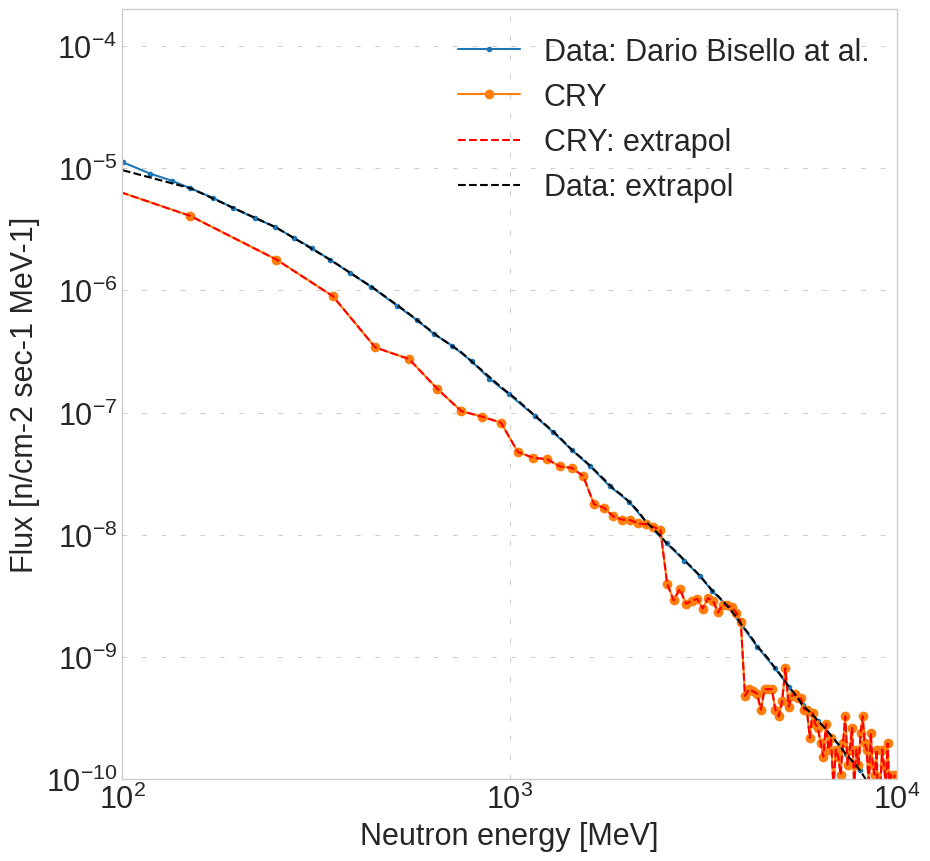

In [7]:
dfData_ = dfData.query('name == "DarioBisello" & energy>100')

plt.figure(figsize=(10,10))
plt.plot(dfData_.energy, dfData_.flux, '.-', label='Data: Dario Bisello at al.')
(counts, bins) = np.histogram(dfCRY.query('name=="NYC_morestat"')['energy'], bins=np.arange(0, 10000, 100))
binSize = bins[1]-bins[0]
timeArea = (CRYinput["NYC_morestat"]*S*binSize)
#*nrows/nrows_read
counts = counts/timeArea
#plt.hist(bins[:-1], bins, weights=counts, histtype='step', label="CRY")
plt.plot(bins[:-1]+binSize/2, counts, '-o', label="CRY")



#Extrapolation
xCRY = bins[:-1]+binSize/2
yCRY = counts
fCRY = interp1d(xCRY, yCRY, kind='linear', fill_value="extrapolate")
fData = interp1d(dfData_.energy, dfData_.flux, kind='linear', fill_value="extrapolate")
#plt.plot(xCRY, yCRY, 'ro', label="CRY")
plt.plot(xCRY, fCRY(xCRY), 'r--', label="CRY: extrapol")
plt.plot(xCRY, fData(xCRY), 'k--', label="Data: extrapol")
plt.yscale('log')
plt.xscale('log')

plt.ylim(1e-10, 2e-4)
plt.xlim(100, 10000)
plt.legend()


plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.ylim(1e-10, 2e-4)
plt.xlim(100, 10000)
plt.xlabel('Neutron energy [MeV]')
plt.ylabel('Flux [n/cm-2 sec-1 MeV-1]');

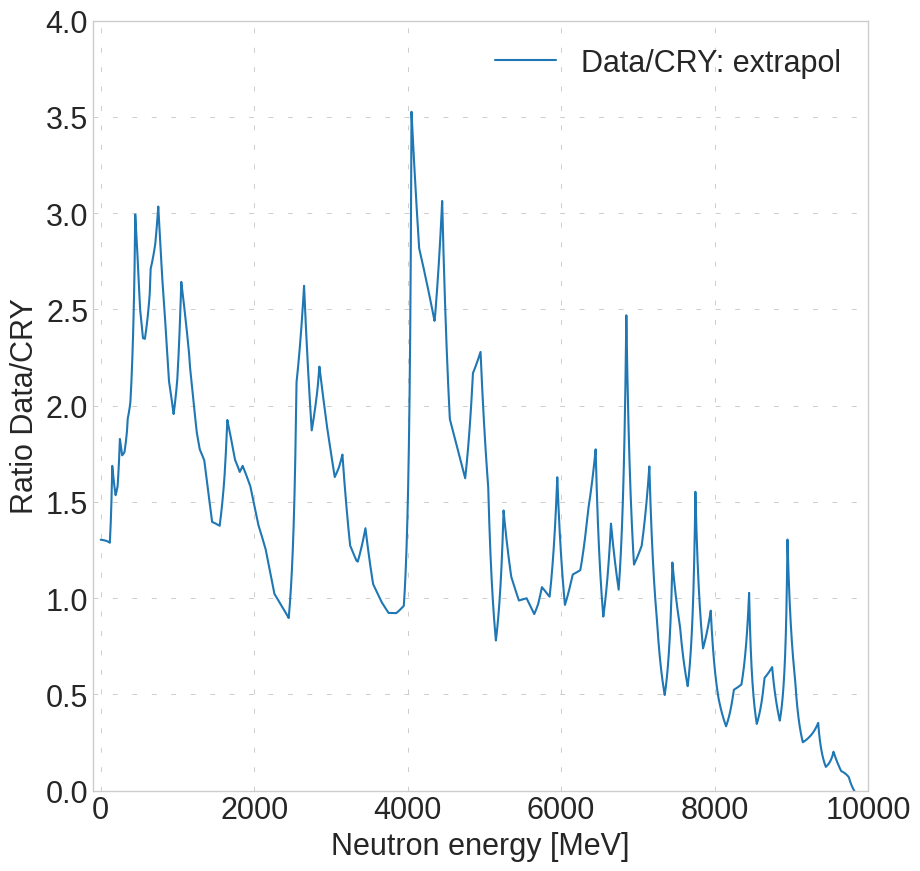

In [8]:
plt.figure(figsize=(10,10))
xEn = np.arange(0, 10000, 1)

fRatio = interp1d(xEn, fData(xEn)/fCRY(xEn), kind='linear',  fill_value="extrapolate")
plt.plot(xEn, fRatio(xEn), '-', label='Data/CRY: extrapol')
plt.xlim(-100, 10000)
plt.ylim(0, 4)
plt.legend()
plt.xlabel('Neutron energy [MeV]')
plt.ylabel('Ratio Data/CRY');

#Neutrons only from CRY4

In [9]:
cry4s2neut_root = 'drive/MyDrive/root_files_cry4/nts.owner.cry4s2neut.version.sequencer.root'
file = uproot3.open(cry4s2neut_root)
trkana = file["HitDumper"]["nt"]
dfCRY4s2neut = trkana.pandas.df(flatten=True)

#Plot CRY4

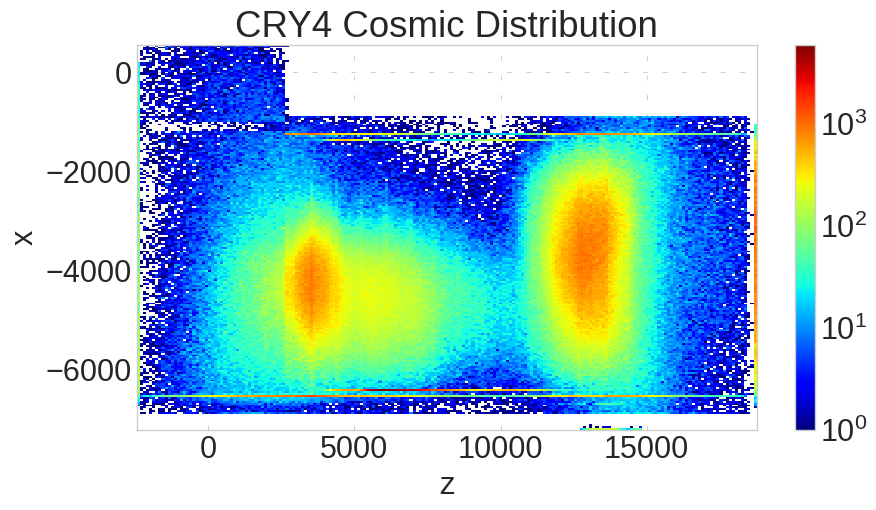

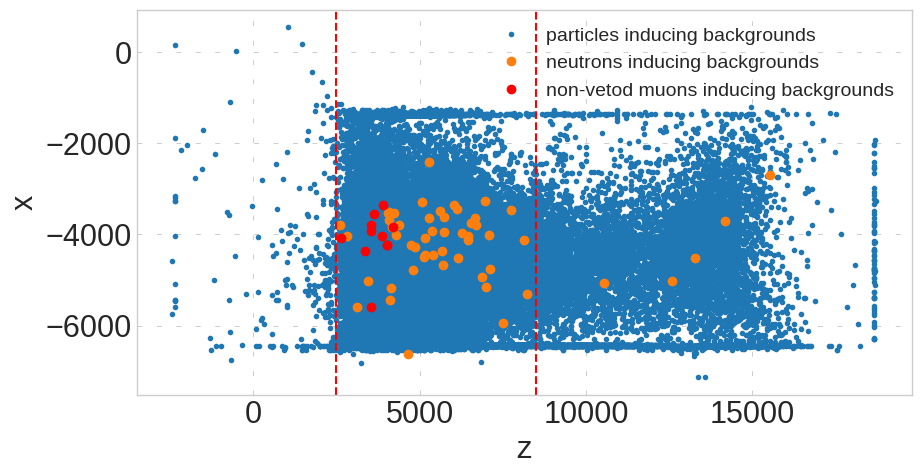

In [10]:
try:
    dfCRY4
except NameError:
    dfCRY4 = pd.read_hdf(main_path + "root_files_cry4/cry4df.h5").query('(lyield==15000)')

plotted = dfCRY4.query('crvinfo__timeWindowStart>0')
plt.hist2d(plotted['crvinfomc__z'], plotted['crvinfomc__x'], bins=(200,200), norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet);
plt.colorbar();
plt.title("CRY4 Cosmic Distribution");
plt.xlabel("z");
plt.ylabel("x");

plt.figure()
plotted = dfCRY4.query(cuts.cut_loose+' & (_z>-10000)')
plt.plot(plotted['_z'], plotted['_x'], '.', label='particles inducing backgrounds');

#plotted = dfCRY4.query(cuts.cut_loose+'& (demcgen_pdg==2112 & _z>-10000)')
plotted = dfCRY4.query(cuts.cut_loose+'& (demcgen_pdg==2112 & _z>-10000)')
#plt.plot(plotted['_z'], plotted['_x'], 'o', label='neutrons inducing backgrounds');
plt.plot(dfCRY4s2neut['hits.z'], dfCRY4s2neut['hits.x'], 'o', label='neutrons inducing backgrounds')


plotted = dfCRY4.query('_crvSectorNumber==9 & crvinfo__PEs<0 & abs(_pdgId)==13  & is_high==1')
plt.plot(plotted['_z'], plotted['_x'], 'ro', label='non-vetod muons inducing backgrounds');

plt.axvline(x=2500, color='r', linestyle='--')
plt.axvline(x=8500, color='r', linestyle='--')

plt.legend(prop={'size': 14})
plt.xlabel("z");
plt.ylabel("x");

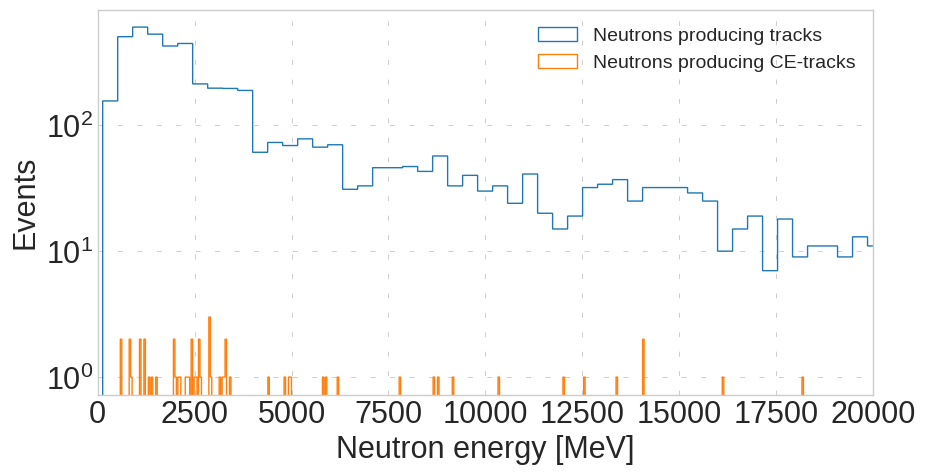

In [11]:
plt.xlabel('Neutron energy [MeV]')
plt.ylabel('Events')
plt.hist(GetNeutKE(dfCRY4), histtype='step', bins=1000, label='Neutrons producing tracks');
plt.hist(GetNeutKE(dfCRY4.query(cuts.cut_current)), histtype='step', bins=1000, label='Neutrons producing CE-tracks');
plt.legend(prop={'size': 14})
plt.yscale('log')
plt.xlim(0, 20000);

In [12]:
neve_extmom = len(dfCRY4.query(cuts.cut_extmom))
neve_physmom = len(dfCRY4.query(cuts.cut_phymom))
mom_scale = neve_extmom/neve_physmom
print('Momentum scale: %2.1f'% mom_scale)
ave, err, _, _, _, _ = utils.getNormBackground(dfCRY4, cuts.cut_current+'& abs(demcgen_pdg)!=13', mom_scale)
print('Non muon background: %2.3f +/- %2.3f'%(ave*1.2, err*np.sqrt(1.2)))

ave, err, _, _, _, _ = utils.getNormBackground(dfCRY4, cuts.cut_current+'& demcgen_pdg==2112', mom_scale)
print('Neutron background: %2.3f +/- %2.3f'%(ave*1.2, err*np.sqrt(1.2)))

Momentum scale: 34.7
Non muon background: 0.047 +/- 0.005
Neutron background: 0.042 +/- 0.005


In [13]:
neutKEarr = GetNeutKE(dfCRY4.query(cuts.cut_current))
weighted_number_nuetrons = fRatio(neutKEarr).clip(min=1).sum() # FIXME. Currently consider weights above 1 only to get rid off unphysical values.
print('Weighted %.1f and unweighted %.1f number of neutrons' % (weighted_number_nuetrons, len(neutKEarr)))

Weighted 97.5 and unweighted 65.0 number of neutrons


#Print event IDs of neutron events

In [14]:
from tabulate import tabulate
df_neutID = dfCRY4.query(cuts.cut_nomom+'& (demcgen_pdg==2112)')[['evtinfo__subrunid', 'evtinfo__eventid']]
df_neutID['runID'] = 2701
df_neutID = df_neutID[['runID','evtinfo__subrunid', 'evtinfo__eventid']]
print(tabulate(df_neutID, headers="", tablefmt="presto", showindex=False))

 2701 |   3486 | 370887
 2701 |   5877 | 224596
 2701 |   6665 |  29828
 2701 |   8301 | 483516
 2701 |  11034 | 320621
 2701 |  15779 | 497037
 2701 |  16475 | 148071
 2701 |  17269 | 263332
 2701 |  17326 |  55583
 2701 |  18900 | 438496
 2701 |  19880 | 315748
 2701 |  24960 | 241609
 2701 |  31780 | 171212
 2701 |  32596 | 230617
 2701 |  35824 | 231009
 2701 |  36181 | 187451
 2701 |  46625 | 434980
 2701 |  48994 |  73954
 2701 |   1845 | 121757
 2701 |   2351 | 425653
 2701 |   5589 | 375997
 2701 |   8360 | 108045
 2701 |  15696 | 377244
 2701 |  17789 | 213974
 2701 |  20252 | 234024
 2701 |  21976 | 245641
 2701 |  30257 | 362281
 2701 |  35518 | 491541
 2701 |  46836 | 151254
 2701 |  47851 | 137992
 2701 |  50322 |  36146
 2701 |  52094 | 233397
 2701 |  59490 | 348827
 2701 |  63803 | 359990
 2701 |  64619 | 183619
 2701 |  65659 | 373833
 2701 |  68510 | 340828
 2701 |  70904 | 108735
 2701 |  71935 | 475021
 2701 |  72364 | 270507
 2701 |  75272 | 426312
 2701 |  77423 |